In [16]:
# loading all the dependencies
import pandas as pd
from openpyxl import load_workbook
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

import numpy as np
import uncertainties as uc

pd.options.display.float_format ='{:,.2f}'.format
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image
from IPython.core.display import HTML 


import scipy.stats as stats
from uncertainties import ufloat
from uncertainties import unumpy

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values 

# Brain cells
Consist mainly of neurons and non-neuron cells: glial and endothelial cells

## Number of cells
The number of different cells were estimated by several different methods over the years, including: stereology, histology and (recently) Isotropic Fractionator. Using these kinds of methods, researches have refuted the well known claim that glial cells overwhelm the nueron cells by factor of 10.
In this section we base our estimates for the number of the cells of the different cell types, on three main sources:
[Azevedo et al., 2009](https://www.ncbi.nlm.nih.gov/pubmed/19226510)
[Andrade-Moraes et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/24136825)
[von Bartheld et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5063692/#R105)

We average the estimates from  [Azevedo et al., 2009](https://www.ncbi.nlm.nih.gov/pubmed/19226510) and [Andrade-Moraes et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/24136825) to get the numbers for neurons and non-neurons cells in the different segments of the brain. Then, we use the estimates of [von Bartheld et al., 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5063692/#R105) for the distribution of non-neuron cells, to diffrentiate between them.



In [3]:
#reading from excel the neuron and non-neuron cell pupulation estimates (average from Azevedo and Andeade-Moraes)
cells_populations = pd.read_excel('Brain_data.xlsx','Neuron_and_nonN_populations',index_col=0, usecols = range(10))


nonN_dist = pd.read_excel('Brain_data.xlsx','nonNeuron_population',index_col=0, usecols = range(9))
#nonN_dist.head()



#joining the two data frames, considering the type (gery/white) matter of the brain part
cells_populations=cells_populations.join(nonN_dist, on='type')


nonN_types = ['Oligodendrocytes','Astrocytes','Microglia','endothelial cells']

#computing the total numbers of different non_N cells. using the uncertainty package for uncertainties computations
dist_matrix = unumpy.umatrix(cells_populations[nonN_types].values,
            cells_populations[['std olig.','std Ast.','std Microg.','std end.']].values)

total_nonN = unumpy.uarray(cells_populations.loc[:,'Absolute non-neuronal number (billion)'].values,
                  cells_populations.loc[:,'Delta non-neuronal number (billion)'].values)

#transposing the matrix and using the dot methodfor scallar multiplication 
#nonN_nums = np.dot(dist_matrix.transpose(1,0),total_nonN)
#nonN_nums = np.array(nonN_nums).ravel()  #using ravel to transform from matrix to an array

#by matrix multiplication by a diagonal matrix create martix where each row represent cell type and columns are brain part 
nonN_nums =dist_matrix.transpose(1,0)*np.diag(total_nonN)

#computing the total number of neurons and its uncertainty
Neu_num = unumpy.uarray(cells_populations.loc[:,'Absolute neuronal number (billion)'].values,
                  cells_populations.loc[:,'Delta neuronal number (billion)'].values)

#combining into a single data frame the numebr estimates for all the different cells           
total_cells= pd.DataFrame(Neu_num.reshape(1,-1), index=['Neurons'], columns= cells_populations.index)
total_cells = total_cells.append(pd.DataFrame(nonN_nums,index=nonN_types,columns= cells_populations.index))


#printing the number of different cells
for cell_type in total_cells.index :
    print(cell_type,': {:0.1eP} '.format(10**9*total_cells.loc[cell_type,:].sum()))

    
#initiating a CellTypeResDF object to save results and print them:
brain_cells = CellTypesResDF(['Neurons','Glial cells'])
brain_cells.res.loc['Neurons','number'] = 10**9*total_cells.loc['Neurons'].sum()
brain_cells.res.loc['Glial cells','number'] = 10**9*total_cells.loc[['Oligodendrocytes','Astrocytes','Microglia']].sum().sum()


Neurons : (7.7±1.1)×10¹⁰ 
Oligodendrocytes : (4.0±0.4)×10¹⁰ 
Astrocytes : (1.8±0.2)×10¹⁰ 
Microglia : (5.9±1.2)×10⁹ 
endothelial cells : (1.7±0.2)×10¹⁰ 


## Age and Lifespans

There is a ongoing debate regarding the occurrence of neurongenesis in human brain, specificly in the hippocampus.
[Sorrells et al., 2018](https://www.nature.com/articles/nature25975) foung no evidence of new neurons in adults hippocampus. They used DCX and PSA-NCAM markers. Didn't find double positive (DCX+PSA-NCAM+) marked cells  ("young neurons") in the hilus or GCL of the hippocampuses brains of adults (17 individuals, aged 18-77 years).
However, [Moreno-Jiménez et al., 2019](https://www.nature.com/articles/s41591-019-0375-9) used an improved method and found population of young neurons (positive for DCX plus other markers as PSA-NCAM+ and more) in the hippocampus of adult patients, up to the ninth decade of their life. They postulate that [Sorrells et al., 2018](https://www.nature.com/articles/nature25975) negative results might have been due to the prolonged or uncontrolled fixation conditions to which humansamples are typically exposed in brain banks worldwide, which as they demonstrated, lead to a sharp reduction in the number of DCX+ cells detected.
[Boldrini et al., 2018](https://www.sciencedirect.com/science/article/pii/S1934590918301218?via%3Dihub) also shows a young neuron population in the dentate gyri in the hippocampus of adults.


We integrated several quantitative sources regarding the average age and turnover of neurons and brain cells in general.
neuronogenesis is limited to only few parts in the human brain:

[Bhardwaj et al., 2006](https://www.pnas.org/content/103/33/12564) - no neuronogenesis in the cortex. 
upper bound - 0.07% of cells are new (5 years) - under the threshold of measurement

[Spalding et al., 2013](https://www.sciencedirect.com/science/article/pii/S0092867413005333?via%3Dihub#mmc1) - neuronogenesis in the hippocampus !
matched several models for the data. Seems that the best model was taking in acount 2 different population, one that is regenerated and one that isn't (only dying). Their results indicate that over half of the non-neurons cells of the hippocampus are turnover, and about third of the neurons. Fitting the theory that most of the regeneration is in the dentate gyrus part.


[Spalding et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16009139) - age of neurons in cerebellum and occipital-cortex is about the age of the person. Non-nuerons cells are younger by~10 years

[Ernst et al., 2014](https://www.ncbi.nlm.nih.gov/pubmed/24561062) - There is neurogenesis in the Striatum. With a similar 2 population model they showed that about quarter of the neurons in the Striatum are turnover in reletivly fast rate.
They also differentiated between Oligodendrocytes and the other non-neurons and measured their turnover rate.

[Bergmann et al., 2012](https://www.sciencedirect.com/science/article/pii/S0896627312003418) - The average age of neurons in the olfactory bulb is the same as the person, therfore no nuerogensis in the olfactory bulb, in humans. As opposed to a known phenomena of neurogenesis in the olfactory bulb of rodents.


[Reu et al., 2017](https://www.cell.com/cell-reports/fulltext/S2211-1247(17)30943-9) - The average age of microglia in the cortex is a about 4.2 years, indicating a turnover of 28% yearly.

### The turnover of non-Neurons in the cortex
Using data from [Bhardwaj et al., 2006](https://www.pnas.org/content/103/33/12564) and [Spalding et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16009139) we estimate the turnover rate of non-Neuron cells in the cortex, based on their measured average age. 
We base our estimate on two simple models: 
1. All cells were born with the person, but for a constant small production and turnover rate
2. Same as 1, only with a specific sub-population (fraction) that are being subjected to turnover. 

equation for 1:
constant production and turnover rate $\beta = \gamma$ (units: 1/year),  
$$\frac{dN}{dt} =(\beta-\gamma)N = 0.$$
$$ N(t) = N_{0}$$

$ n(t,a) = \gamma N e^{-\gamma a}$  ,for $a<t$ ($a$ is the age of cells, and $t$ the age of the person
$$ n(t,t) = N_{0}e^{-\gamma t} $$

We can get an experssion for the average age of the cells:
$$<a> =\frac{\int a n(t,a)da}{N(t)} = \frac{\int \gamma N_{0}a e^{-\gamma a}da}{N_{0}}=\gamma \int a e^{-\gamma a}da+te^{-\gamma t} = \frac{1-e^{-\gamma t}}{\gamma}$$


for 2 we get similary:
f is the fraction of the population that undergo turnover

$$<a> = (1-f)t+ f\frac{1-e^{-\gamma t}}{\gamma}$$





patient specific turnover rate:
average turnover rate: 0.8±0.1%


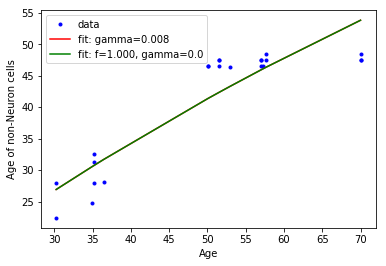

RMSE: 3.9 


In [18]:
age_cortex = pd.read_excel('Brain_data.xlsx','age_neuN_Cortex',index_col=0, usecols = range(7))
age_cortex= age_cortex.sort_values('patient age [y]',ascending = 0) #sorting by the age of the patients. easyer to plot

t=age_cortex.loc[:,'patient age [y]'].values
neuN_ages=age_cortex.loc[:,'neuN age [y]'].values 
#t=53
#neuN_ages=42


#defining the equation (average age of cell when there is constant production) as a function that can be numerily solved
equation = lambda g,a : (1 - np.exp(-g*t))/g - a
#defining initial geuss. we now that gamma is <1 

gamma_initial_guess=0.01*np.ones(len(age_cortex))

#print(gamma_initial_guess.shape)
#print(t.shape)
#print(neuN_ages.shape)
gamma = fsolve(equation, gamma_initial_guess, args=neuN_ages)


##estimating the error by solving the equation for the limits of possible range
neuN_ages_hi = neuN_ages + 2*np.ones(len(age_cortex)) # the precision of the measuring the average age method bt c14 is +- 2 years
neuN_ages_low = neuN_ages - 2*np.ones(len(age_cortex))

gamma_hi = fsolve(equation, gamma_initial_guess ,args=neuN_ages_low)
gamma_low = fsolve(equation, gamma_initial_guess ,args=neuN_ages_hi)


#and now we store the value in ufloat
gamma = unumpy.uarray(gamma, (gamma_hi-gamma_low)/2)

print('patient specific turnover rate:')
#for g in gamma :
#    print('{:0.1fP}%'.format(100*g))


cortical_nonN_turnover = gamma.mean()
print('average turnover rate: {:0.1fP}%'.format(100*cortical_nonN_turnover))



################################################
#Altrnative method is to try to fit the different models to the average age data from the sourcses
# as will show, it gives the same results
###############################################

#the essence of the first model to fit is the same as solving the simple equation of average age with constant turnover

#defining the fucntion of average age for constant turnover
const_turn = lambda t,gamma : (1 - np.exp(-gamma*t))/gamma

#fitting the data using curve_fit
popt, pcov = curve_fit(const_turn, t, neuN_ages)

#ploting the data and the fit
plt.plot(t, neuN_ages, 'b.', label='data')
plt.plot(t, const_turn(t, *popt), 'r-',label='fit: gamma=%0.3f' % tuple(popt))


#defining the fucntion of average age for 2 population, one of which has constant turnover
pop2 = lambda t,f,gamma: (1-f)*t+ f*(1 - np.exp(-gamma*t))/gamma

#fitting the data using curve_fit
popt, pcov =curve_fit(pop2, t, neuN_ages,bounds=(0, [1., 1.]))

#ploting the data and the fit
plt.plot(t, pop2(t, *popt), 'g-',label='fit: f=%0.3f, gamma=%0.1f'  % tuple(popt))
plt.xlabel('Age')
plt.ylabel('Age of non-Neuron cells')
plt.legend()
plt.show()    

#caclulating measures of goodnes of fit
absError = pop2(t, *popt) - neuN_ages
SE = np.square(absError) 
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE)

# print('MSE: ',MSE)
print('RMSE: {:0.1f} '.format(RMSE))



And we can see that in the 2 population model we get a trivial case, all the population is under constant turnover rate. 
we will use this value for non-neuron cell in the cortex


## Turnover rate for different brain segments
We use the data gather from: [Bhardwaj et al., 2006](https://www.pnas.org/content/103/33/12564), 
[Spalding et al., 2013](https://www.sciencedirect.com/science/article/pii/S0092867413005333?via%3Dihub#mmc1) 
[Spalding et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16009139)
[Ernst et al., 2014](https://www.ncbi.nlm.nih.gov/pubmed/24561062)
[Bergmann et al., 2012](https://www.sciencedirect.com/science/article/pii/S0896627312003418)
[Reu et al., 2017](https://www.cell.com/cell-reports/fulltext/S2211-1247(17)30943-9)

We assume the non-zero turnoevr rates for neurons is restricted to the regions in which it was found. 
for non neuron cells, we assume:
1. Microglial turnover rates that were measured in the Cortex are representative for the entire brain
2. Oligodendrocytes turnover rates that were measured in the Striatum are representative for the entire brain
3. Endothelial turnover rates are similiar to the other non-neuron cells. In [Bergmann et al., 2015](https://www.ncbi.nlm.nih.gov/pubmed/26073943)  it was etimated that in the heart, endothelial cells turvnoer is 17% per year, but it seems that it doesn't hold for the ednothalial cells in the brain, as the overall age of Cortex cells is too high. We think that that might be due to lower erosion of the blood vessels in the brain.
We compare the expected turnover rate of non-neuron cells that was measured in the different parts of the brian, to these we compute from indivdual cell type prevalence and measured turnover and conclude a reference turnover for the population of glial cells.


In [5]:
#uploading the data regarding the turnover of the different cell type and different brain parts  
turnover_data = pd.read_excel('Brain_data.xlsx','Cells_turnover',index_col=0, usecols = range(0,7))

renewing_popul = pd.DataFrame(index=total_cells.index, columns=total_cells.columns) #stores the fraction of renewing population
rp_turnover_rates = pd.DataFrame(index=total_cells.index, columns=total_cells.columns)  #stores the turnover rate of the renewing populatio


#assiging the turvnoer data by brain part and cell type
for cell_type in renewing_popul.index:  #going over all cell types
    for part in renewing_popul.columns:  #going over all brain parts
        current_turnover = turnover_data.loc[(turnover_data.index == part) & (turnover_data['cells'] == cell_type)]
        #chechking if their is relevant data
        if len(current_turnover.index)>0:
            renewing_popul.loc[cell_type,part] = ufloat(current_turnover['% population regenerated'].mean(axis=0),
                                                        current_turnover['std population regenerated'].mean(axis=0))
            #assigning the mean of all relevant entries and the standard deviations
            rp_turnover_rates.loc[cell_type,part] = ufloat(current_turnover['turnover rate % per y'].mean(axis=0),
                                                           current_turnover['turover rate std'].mean(axis=0))


rp_turnover_rates

brain part,Cortex,Subcortical White Matter,Cerebellum,Striatum,Hippocampus,ROB
Neurons,0.0+/-0,NaN,0.0+/-0,0.027+/-0,0.0175+/-0,NaN
Oligodendrocytes,NaN,NaN,NaN,0.013+/-0.005,NaN,NaN
Astrocytes,NaN,NaN,NaN,NaN,NaN,NaN
Microglia,0.28+/-0.15,NaN,NaN,NaN,NaN,NaN
endothelial cells,NaN,NaN,NaN,NaN,NaN,NaN


### Non-neuron cells turnover
We first estiamate the turnover and lifespan of non-Neuron cells

In [6]:

#glial and endothelial cells 

##using an assumption that the turnover rates that was measured for glial cells in certain brain parts hold for the rest
#we use the expected turnover rate for the comparison - given by the multiplication of the fraction of renewed population in its turnover rate 
exp_to = renewing_popul*rp_turnover_rates

#removing the neurons for convenient
exp_to = exp_to.drop('Neurons')

exp_to = exp_to.sum(axis=1)



#assigning the expected turnover of non-Neuron cells from the literature, by brain part
measured_turnover = pd.DataFrame(index=['non-Neurons','non-Neurons, non Oligodendrocytes'], columns=total_cells.columns)  #stores the turnover rate of the renewing populatio
for cell_type in measured_turnover .index:  #going over the two indices
    for part in measured_turnover .columns:  #going over all brain parts
        current_turnover = turnover_data.loc[(turnover_data.index == part) & (turnover_data['cells'] ==cell_type)]
        if len(current_turnover.index)>0:
            measured_turnover.loc[cell_type,part] = ufloat(current_turnover.loc[:,'% population regenerated'].mean(axis=0),
                                                        current_turnover.loc[:,'std population regenerated'].mean(axis=0))
            measured_turnover.loc[cell_type,part]=measured_turnover.loc[cell_type,part]*ufloat(current_turnover.loc[:,'turnover rate % per y'].mean(axis=0),
                                                        current_turnover.loc[:,'turover rate std'].mean(axis=0))

#adding the turnover rate for non-Neurons in the cortex we estimated from previous data:
measured_turnover.loc['non-Neurons','Cortex'] = cortical_nonN_turnover

#deriving estimatr for the overall non-Neuron cells in the Striatum using known values for Oligodendrocytes and non-Neurons, non Oligodendrocytes'
ind = ~measured_turnover.loc['non-Neurons, non Oligodendrocytes',:].isnull()# indices with second entry not triviall

#dist_matrix is the distribution of non-neuron cells
dist_nonN = pd.DataFrame(dist_matrix.T, index=nonN_types, columns=total_cells.columns) #stores the fraction of renewing population

nonO= nonN_types.copy()
nonO.remove('Oligodendrocytes')

measured_turnover.loc['non-Neurons',ind] = exp_to['Oligodendrocytes'].nominal_value*unumpy.nominal_values(dist_nonN.loc['Oligodendrocytes',ind]).mean()
measured_turnover.loc['non-Neurons',ind] =measured_turnover.loc['non-Neurons',ind]+measured_turnover.loc['non-Neurons, non Oligodendrocytes',ind]*dist_nonN.loc[nonO,ind].sum(axis=0)

for part in measured_turnover.columns[~measured_turnover.loc['non-Neurons',:].isnull()]:
     print('estimated turnoevr of non-neurons in',part,': {:0.1fP}% per year'.format(100*measured_turnover.loc['non-Neurons',part]))

######
#deriving computed lower bound for non-Neuron cells turnover from known turnover of cells types (Oligodendrocytes and Microglia)
nonN_to_lo_bound = pd.Series(np.dot(exp_to,dist_nonN),index = dist_nonN.columns)

#and beacuse the difference between the estimates is well within the uncertainty we take the mean
nonN_to_lo_bound = np.dot(exp_to,dist_nonN).mean()
print('______________')
print('lower bound for non-neuron cells turnoevr: {:0.1fP}% per year'.format(100*nonN_to_lo_bound))


estimated turnoevr of non-neurons in Cortex : 0.8±0.1% per year
estimated turnoevr of non-neurons in Striatum : 2.5±0.5% per year
estimated turnoevr of non-neurons in Hippocampus : 2.7±0.7% per year
______________
lower bound for non-neuron cells turnoevr: 2.7±1.2% per year


As we can see there is a discrepancy between the bound we get, and the turnover we estimate for the non-neuron in the cortex.
Possible explanation for the discrepancy are the use of different models to assess the turnover from average age data,  large errors in the measurements, or the difference between brain parts. However, Microglia turnvoer was assessed in the cortex, in its turnvoer alone is higher than we estimated for the all non-neuron population in the cortex.

We chose to take the average of the two extremist with the uncertainty deriven from it, to take into consideration the large discrepancy and to reflect the uncertainty.  


In [8]:
glia_per_to = ufloat(0.5*(measured_turnover.loc['non-Neurons','Cortex'].nominal_value+nonN_to_lo_bound.nominal_value),
                        0.5*(nonN_to_lo_bound.nominal_value-measured_turnover.loc['non-Neurons','Cortex'].nominal_value))
#the reference turnover in % per year

#the total effective lifespan is given as 1 over the percentage turnover, converted to years
brain_cells.res.loc['Glial cells','lifespan'] = 365/glia_per_to
brain_cells.res.loc['Glial cells','cellular turnover rate'] = brain_cells.res.loc['Glial cells','number']*glia_per_to/365
 

    
print('Glial turnover rate:{:0.1fP} % per year'.format(100*glia_per_to ))
#using a dedicated method that prints the results in years:
brain_cells.print_in_years(['lifespan','cellular turnover rate'],'Glial cells')

brain_cells.print_params(['lifespan','cellular turnover rate'],'Glial cells')


endothel_num = 10**9*total_cells.loc['endothelial cells'].sum()
print('Brain endothelial cells turnover rate:{:0.1eP} cells per year'.format(endothel_num*glia_per_to ))






Glial turnover rate:1.7±0.9 % per year
Lifespan of Glial cells is: 60±30 years
Cellular turnover rate of Glial cells is: (1±1)×10⁹ cells per year
Lifespan of Glial cells is: 21000±11000 days
Cellular turnover rate of Glial cells is: (3.1±1.6)×10⁶ cells per day
Brain endothelial cells turnover rate:(3.1±1.6)×10⁸ cells per year


### Neuron turnvoer and lifespan
We first estimate the turnover of neuron according to the sources mentioned, assuming  the non-zero turnoevr rates for neurons is restricted to the regions in which it was found. 

In [9]:
#assuming no neurogensis in other parts of the brain.         

renewing_popul.loc['Neurons',renewing_popul.isnull().loc['Neurons',:]] = 0
rp_turnover_rates.loc['Neurons',rp_turnover_rates.isnull().loc['Neurons',:]] = 0
              
neurons_renewing_turnoevr = 10**9*np.dot(total_cells.loc['Neurons',:],(renewing_popul*rp_turnover_rates).loc['Neurons',:])  #neurons per y
print('Neurons renewing turnover rate:{:0.1eP} cells per year'.format(neurons_renewing_turnoevr))
print('Neurons renewing turnover rate:{:0.1eP} cells per day'.format(neurons_renewing_turnoevr/365))

# neurons_num = total_cells.loc['Neurons',:].sum(axis=0)
neu_percent_turvnoer = neurons_renewing_turnoevr/brain_cells.res.loc['Neurons','number']
print('Neurons renewing turnover rate:{:0.4fP} % per year'.format(100*neu_percent_turvnoer ))

neuron_lifespan_from_to = 1/neu_percent_turvnoer  #aggregate lifespan in years
print('mean neuron lifespan from renewing turnover:{:0.0eP} years'.format(neuron_lifespan_from_to))


Neurons renewing turnover rate:(9.5±3.1)×10⁵ cells per year
Neurons renewing turnover rate:(2.6±0.8)×10³ cells per day
Neurons renewing turnover rate:0.0012±0.0004 % per year
mean neuron lifespan from renewing turnover:(8±3)×10⁴ years


In addition there could be loss of neurons over the year in the non-renewing population. Such loss of cell would not affect the measurement of average age and so won't change the previous results.

The effect of age on the number of cortical neurons was estimated by [Pakkenberg and Gundersen, 1997](https://www.ncbi.nlm.nih.gov/pubmed/9215725) to be 10% over the range between 20 and 90 years old.
Assuming constant rate of death we can have another estimate for the lifespan of neurons in the cortex (and we can assume it represent the whole brain)

The regression show poor correlation:R**2=0.24


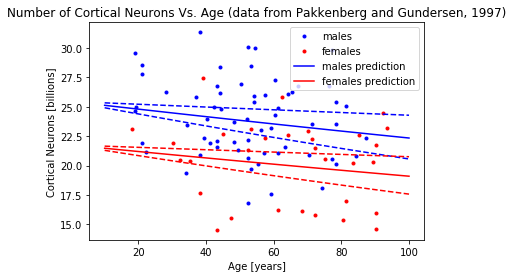

Neuron death rate is  0.13±0.08% per year
Neuron lifespan is 800±500 years


In [26]:
cor_neu_age = pd.read_excel('Brain_data.xlsx','Pakkenberg and Gundersen, 1997', usecols = range(0,4))
y = cor_neu_age[['cortex neurons (billions)']]
X=cor_neu_age[['male','age']]
y=np.log(y)  #assuming constant death rate gives an exponential model as we saw in details earlier 

# simple way to do regression but without estimation of the error 
#model = LinearRegression().fit(X,y)
#r_sq= model.score(X,y)
#print(model.coef_)

#using OLS method from statsmodels.api to do regression with error estimate for the coefficient
# include constant in ols models, which is not done by default
X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

#poor regression results:
print('The regression show poor correlation:R**2={:0.2f}'.format(results.rsquared))

#seperating the male and females for plotting
X['age'].where(X['male']==1)
males_age = X[X['male']==1]['age']
females_age = X[X['male']==0]['age']
#returning from log to regular units
males_co_ne=np.exp(y[X['male']==1])
females_co_ne=np.exp(y[X['male']==0])

#for ploting, using the parameters from the model
x_for_pred = np.linspace(10,100).reshape(-1,1)


#calculating the model predictions, including the standard error for the age slopes
y_pred_male = np.exp(results.params.const +results.params.male + results.params.age*x_for_pred)
y_pred_male_hi = np.exp(results.params.const +results.params.male + (results.params.age+results.bse.age)*x_for_pred)
y_pred_male_low = np.exp(results.params.const +results.params.male +(results.params.age-results.bse.age)*x_for_pred)


y_pred_female = np.exp(results.params.const + results.params.age*x_for_pred)
y_pred_female_hi = np.exp(results.params.const + (results.params.age+results.bse.age)*x_for_pred)
y_pred_female_low = np.exp(results.params.const +(results.params.age-results.bse.age)*x_for_pred)


#plotting the data and the models, including the possible ranges of error (1 SE)
plt.plot(males_age, males_co_ne, 'b.', label='males')
plt.plot(females_age, females_co_ne, 'r.', label='females')

plt.plot(x_for_pred , y_pred_male, 'b-', label='males prediction')
plt.plot(x_for_pred , y_pred_male_hi, 'b--')
plt.plot(x_for_pred , y_pred_male_low, 'b--')


plt.plot(x_for_pred , y_pred_female, 'r-', label='females prediction')
plt.plot(x_for_pred , y_pred_female_hi, 'r--')
plt.plot(x_for_pred , y_pred_female_low, 'r--')

plt.xlabel('Age [years]')
plt.ylabel('Cortical Neurons [billions]')
plt.title('Number of Cortical Neurons Vs. Age (data from Pakkenberg and Gundersen, 1997)')
plt.legend()
plt.show()


#concluding the death rate of cortical neurons and its uncertainty:
neuron_death_rate=ufloat(-results.params['age'],results.bse['age'])
print('Neuron death rate is {: 0.2fP}% per year'.format(100*neuron_death_rate))
print('Neuron lifespan is {:0.0fP} years'.format(round_vec(1/neuron_death_rate)))


As the estimated death rate is dominant in comparison with the turnover rate in the Hippocampus and Striatum, we get a similar estimate for the overall lifespan of Neurons

In [27]:
total_neuron_death_rate = neuron_death_rate+neu_percent_turvnoer #combining the turnover with death rate, to get % death/year

brain_cells.res.loc['Neurons','lifespan'] = 365/total_neuron_death_rate #in days
brain_cells.res.loc['Neurons','cellular turnover rate'] = brain_cells.res.loc['Neurons','number']/brain_cells.res.loc['Neurons','lifespan']  

neuron_lifespan = 1/total_neuron_death_rate
neuron_lifespan = ufloat(round(neuron_lifespan.nominal_value,-2),round(neuron_lifespan.std_dev,-2))

print('Neurons production rate:{:0.1eP} cells per year'.format(neurons_renewing_turnoevr))
print('Neurons production rate:{:0.1eP} cells per day'.format(neurons_renewing_turnoevr/365))
print('______________________')
print('Neurons death rates:')
brain_cells.print_in_years('cellular turnover rate','Neurons')
brain_cells.print_params('cellular turnover rate','Neurons')
print('______________________')
brain_cells.print_in_years('lifespan','Neurons')
brain_cells.print_params('lifespan','Neurons')


Neurons production rate:(9.5±3.1)×10⁵ cells per year
Neurons production rate:(2.6±0.8)×10³ cells per day
______________________
Neurons death rates:
Cellular turnover rate of Neurons is: (1±1)×10⁸ cells per year
Cellular turnover rate of Neurons is: (3.0±2.0)×10⁵ cells per day
______________________
Lifespan of Neurons is: 800±500 years
Lifespan of Neurons is: (3.0±2.0)×10⁵ days


### Cellular mass and cellular mass turnover
We use data regarding the total cellular mass of cells in the brain and the cell population to estimate the cellular mass and through it the cellular mass turnoevr.
We use the formula from [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167)) to get an estimate for the total cellular mass in the brain, based on the potassium concentration from [Snyder et al., 1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023).
Assuming that neuron and glia has similar mass, and endothelial cells have an average mass of approximatly 1000pg [Félétou, 2011](https://www.ncbi.nlm.nih.gov/books/NBK57145/), we compute the average mass of neuron and glial cells.


In [28]:
#uploading the data regarding the cellular mass of brain cells  
mass_data = pd.read_excel('Brain_data.xlsx','Cellular_mass',index_col=0)
#combining the values and uncertainties for computations
cmdt = pd.Series(unumpy.uarray(mass_data['value'].values,mass_data['SD'].values), index =mass_data.index ) #cell mass data

brain_cell_mass = ((cmdt['brain total potassium']/cmdt['potassium molar mass'])*cmdt['cell mass/potassium conc.'])*1000 #convert from mmol to mol
#result in kg

neuron_glia_total_mass = brain_cell_mass*1000 - endothel_num*cmdt['endothelial cell mass']*10**(-12) #moving to grams in both (from kg and pg)

#estimating the mean neuron/glial cell mass by dividing by their total numbers 
brain_cells.res['cell mass'] = 10**12*neuron_glia_total_mass/brain_cells.res['number'].sum() #in pico grams.

print('total cellular mass of neuron and glial cells: {:0.0fP} g'.format(round_vec(neuron_glia_total_mass)))
brain_cells.print_params('cell mass')

total cellular mass of neuron and glial cells: 1000±300 g
Cell mass of Neurons is: 7000±2000 pg
Cell mass of Glial cells is: 7000±2000 pg


Using the average mass we compute the average cellular mass turnover of the cells:

In [29]:

brain_cells.res['total cellular mass'] = brain_cells.res['number']*brain_cells.res['cell mass']/10**12
brain_cells.res['cellular mass turnover rate'] = brain_cells.res['cell mass']*brain_cells.res['cellular turnover rate']/10**12

#calculating seperatly the rate of production from the renewing turnover 
neuron_mass_prod = neurons_renewing_turnoevr*brain_cells.res.loc['Neurons','cell mass']/10**12 #moving from cells/year and pg to grams/year


brain_cells.print_in_years(['total cellular mass','cellular mass turnover rate'],['Glial cells','Neurons'])

# glial_mass_to = 10**9*glial_year_turnover*mean_neuron_mass/10**12 #moving from billions cells/year and pg to grams/year


print('cellular mass turnover production of renewing neurons {:0.1eP} grams per year'.format(neuron_mass_prod))

brain_end_mass_to = endothel_num*glia_per_to*cmdt['endothelial cell mass']/10**12 #moving from billions cells/year and pg to grams/year
print('_'*30)
print('cellular mass turnover rate of brain endothelial cells {:0.1fP} grams per year'.format(brain_end_mass_to), 'or {:0.1eP} grams per day'.format(brain_end_mass_to/365))

Glial cells:
Total cellular mass of Glial cells is: 440±120 grams
Cellular mass turnover rate of Glial cells is: 8.0±5.0 grams per year
______________________________
Neurons:
Total cellular mass of Neurons is: 530±150 grams
Cellular mass turnover rate of Neurons is: 0.7±0.5 grams per year
cellular mass turnover production of renewing neurons (6.5±2.8)×10⁻³ grams per year
______________________________
cellular mass turnover rate of brain endothelial cells 0.4±0.2 grams per year or (1.0±0.6)×10⁻³ grams per day


## Saving the results to excell
So it can be used for summary 

In [30]:
brain_cells.export_to_excel('Summary.xlsx')